## Netdata Anomaly Detection Deepdive

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/netdata/netdata/blob/master/ml/notebooks/netdata_anomaly_detection_deepdive.ipynb)

This notebook will walk through a simplified python based implementation of the C & C++ code in [`netdata/netdata/ml/`](https://github.com/netdata/netdata/tree/master/ml) used to power the [anomaly detection capabilities](https://github.com/netdata/netdata/blob/master/ml/README.md) of the Netdata agent.

The main goal here is to help interested users learn more about how the machine learning works under the hood. If you just want to get started by enabling ml on your agent you can check out these [simple configuration steps](https://learn.netdata.cloud/docs/agent/ml#configuration). 

🚧 **Note**: This functionality is still under active development and considered experimental. Changes might cause the feature to break. We dogfood it internally and among early adopters within the Netdata community to build the feature. If you would like to get involved and help us with some feedback, email us at analytics-ml-team@netdata.cloud or come join us in the [🤖-ml-powered-monitoring](https://discord.gg/4eRSEUpJnc) channel of the Netdata discord. Alternativley, if GitHub is more of your thing, feel free to create a [GitHub discussion](https://github.com/netdata/netdata/discussions?discussions_q=label%3Aarea%2Fml).

In this notebook we will:

1. [**Get raw data**](#get-raw-data): Pull some recent data from one of our demo agents.
2. [**Add some anomalous data**](#add-some-anomalous-data): Be evil and mess up the tail end of the data to make it obviously "anomalous".
3. [**Lets do some ML!**](#lets-do-some-ml): Implement an unsupervised clustering based approach to anomaly detection.
4. [**Lets visualize all this!**](#lets-visualize-all-this): Plot and explore all this visually.
5. [**So, how does it _actually_ work?**](#so-how-does-it-actually-work): Dig a little deeper on what's going on under the hood.

### Imports & Helper Functions

Uncomment and run the next cell to install [netdata-pandas](https://github.com/netdata/netdata-pandas) which we will use to easily pull data from the [Netdata agent REST API](https://learn.netdata.cloud/docs/agent/web/api) into a nice clean [Pandas](https://pandas.pydata.org/) [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) where it will be easier to work with. 

Once you have [netdata-pandas](https://github.com/netdata/netdata-pandas) installed you can comment it back out and rerun the cell to clear the output.

In [1]:
# uncomment the line below (when running in google colab) to install the netdata-pandas library, comment it again when done.
#!pip install netdata-pandas

In [2]:
from datetime import datetime, timedelta
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from netdata_pandas.data import get_data

# helper functions


def preprocess_df(df, lags_n, diffs_n, smooth_n):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, lags and abs values. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)
    
    # take absolute values as last step
    df = abs(df)
    
    return df


def add_shading_to_plot(ax, a, b, t, c='y', alpha=0.2):
    """Helper function to add shading to plot and add legend item.
    """
    plt.axvspan(a, b, color=c, alpha=alpha, lw=0)
    handles, labels = ax.get_legend_handles_labels()
    patch = mpatches.Patch(color=c, label=t, alpha=alpha)
    handles.append(patch) 
    plt.legend(handles=handles)



A full list of all the anomaly detection configuration parameters, and descriptions of each, can be found in the [configuration](https://github.com/netdata/netdata/blob/master/ml/README.md#configuration) section of the [ml readme](https://github.com/netdata/netdata/blob/master/ml/README.md).

Below we will focus on some basic params to decide what data to pull and the main ml params of importance in understanding how it all works.

#### training size/scheduling parameters:
- `train_every`: How often to train or retrain each model.
- `num_samples_to_train`: How much of the recent data to train on, for example 3600 would mean training on the last 1 hour of raw data. The default in the netdata agent currently is 14400, so last 4 hours.

#### feature preprocessing related parameters:
- `num_samples_to_diff`: This is really just a 1 or 0 flag to turn on or off differencing in the feature preprocessing. It defaults to 1 (to take differences) and generally should be left alone.
- `num_samples_to_smooth`: The extent of smoothing (averaging) applied as part of feature preprocessing.
- `num_samples_to_lag`: The number of previous values to also include in our feature vector.

#### anomaly score related parameters:
- `dimension_anomaly_score_threshold`: The threshold on the anomaly score, above which the data it considered anomalous and the [anomaly bit](https://github.com/netdata/netdata/blob/master/ml/README.md#anomaly-bit) is set to 1 (its actually set to 100 in reality but this just to make it behave more like a rate when aggregated in the netdata agent api). By default this is `0.99` which means anything with an anomaly score above 99% is considered anomalous. Decreasing this threshold makes the model more sensitive and will leave to more anomaly bits, increasing it does the opposite.

#### model parameters:
- `n_clusters_per_dimension`: This is the number of clusters to fit for each model, by default it is set to 2 such that 2 cluster [centroids](https://en.wikipedia.org/wiki/Centroid) will be fit for each model.
- `max_iterations`: The maximum number of iterations the fitting of the clusters is allowed to take. In reality the clustering will converge a lot sooner than this.

**Note**: There is much more detailed discussion of all there configuration parameters in the ["Configuration"](https://github.com/netdata/netdata/blob/master/ml/README.md#configuration) section of the ml readme.

In [3]:
# data params
hosts = ['194.182.187.139:19999']#,'194.182.172.55:19999'#,'185.150.9.185:19999'#['london.my-netdata.io']
charts = ['system.cpu']
# if want to just focus on a subset of dims, in this case lets just pick one for simplicity
dims = ['system.cpu|user'] 
last_n_hours = 2
# based on last_n_hours define the relevant 'before' and 'after' params for the netdata rest api on the agent
before = int(datetime.utcnow().timestamp())
after = int((datetime.utcnow() - timedelta(hours=last_n_hours)).timestamp())

# ml params
train_every = 3600
num_samples_to_train = 3600
num_samples_to_diff = 1
num_samples_to_smooth = 3
num_samples_to_lag = 5
dimension_anomaly_score_threshold = 0.99
n_clusters_per_dimension = 2
max_iterations = 1000

Next we will use the `get_data()` function from the [netdata-pandas](https://github.com/netdata/netdata-pandas) library to just pull down our raw data from the agent into a Pandas dataframe.

(7201, 1)
1683108788 1683115988


,system.cpu|user
time_idx,
1683108788,0.495049
1683108789,1.000000
1683108790,0.497512
1683108791,0.000000
1683108792,1.500000


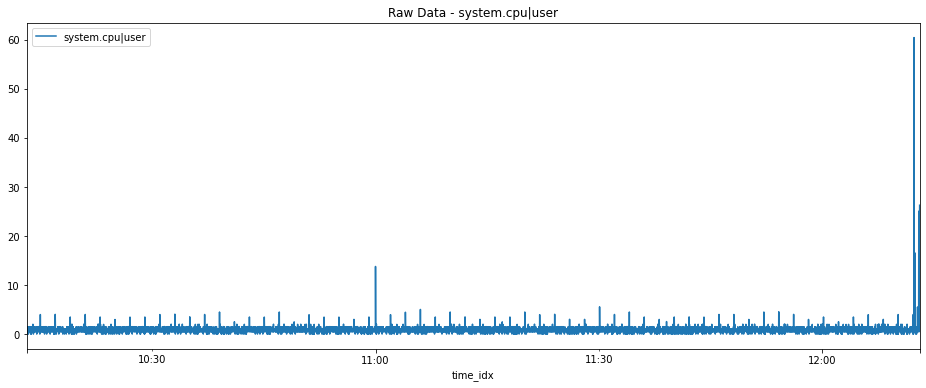

In [4]:
# get raw data
df = get_data(hosts=hosts, charts=charts, after=after, before=before)

# filter df for just the dims if set
if len(dims):
    df = df[[dim for dim in dims]]

# set some variables based on our data
df_timestamp_min = df.index.min()
df_timestamp_max = df.index.max()

# print some info
print(df.shape)
print(df_timestamp_min, df_timestamp_max)
display(df.head())

# lets just plot each dimension to have a look at it
for col in df.columns:    

    # plot dimension, setting index to datetime so its more readable on the plot
    df[[col]].set_index(pd.to_datetime(df.index, unit='s')).plot(title=f'Raw Data - {col}', figsize=(16,6))

### Inputs & Parameters

### 2. Add some anomalous data<a id="add-some-anomalous-data"></a>

Below we will pick the last `n_tail_anomalous` observations and mess them up in some random but noticeable way. In this case we randomly shuffle the data and then multiply each observation by some integer randomly chosen from `integers_to_pick_randomly`

### 1. Get raw data<a id="get-raw-data"></a>

In [5]:
# size of anomalous data
n_tail_anomalous = 500
integers_to_pick_randomly = [0,1,5,10]

# randomly scramble data and multiply randomly by some numbers to make it anomalous looking
anomalous_shape = (n_tail_anomalous, len(df.columns))
randomly_scrambled_data = np.random.choice(df.tail(n_tail_anomalous).values.reshape(-1,), anomalous_shape)
random_integers = np.random.choice(integers_to_pick_randomly, anomalous_shape)
data_anomalous = randomly_scrambled_data * random_integers

# create anomalous dataframe
df_anomalous = pd.DataFrame(data = data_anomalous, columns = df.columns)
# make sure it has the expected index since we don't want to shuffle that
df_anomalous.index = df.tail(n_tail_anomalous).index

# overwrite last n_tail observations with anomalous data
df.update(df_anomalous)

In the plot below it should be clear that the light yellow section of the data has been messed with and is now "anomalous" or "strange looking" in comparison to all the data that comes before it. 

Our goal now is to create some sort of [anomaly score](https://github.com/netdata/netdata/blob/master/ml/README.md#anomaly-score) that can easily capture this.

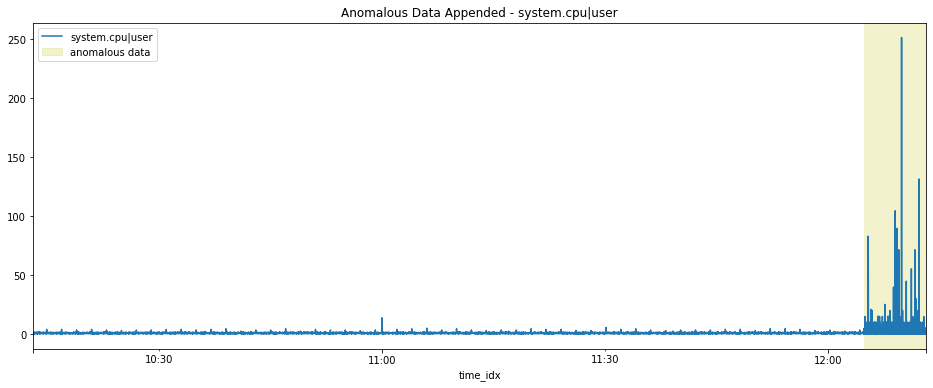

In [6]:
# let's just plot each dimension now that we have added some anomalous data
for col in df.columns:
    
    ax = df.set_index(pd.to_datetime(df.index, unit='s')).plot(title=f'Anomalous Data Appended - {col}', figsize=(16,6))
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'anomalous data')


### 3. Lets do some ML!<a id="lets-do-some-ml"></a>



In this notebook we will just use good old [kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from [scikit-learn](https://scikit-learn.org/stable/index.html). 

In reality the Netdata Agent uses the awesome [dlib](https://github.com/davisking/dlib) c++ library and the [`find_clusters_using_kmeans`](http://dlib.net/ml.html#find_clusters_using_kmeans) function along with a few others. You can see the Netdata KMeans code [here](https://github.com/netdata/netdata/blob/master/ml/kmeans/KMeans.cc).

The code below:

1. Will initialize some empty objects to use during model training and inference.
2. Will loop over every observation and run training and inference in a similar way to how the Agent would process each observation.

Of course the Agent implementation is a lot more efficient and uses more efficient streaming and buffer based approaches as opposed to the fairly naive implementation below. 

The idea in this notebook is to make the general approach as readable and understandable as possible.

In [7]:
# initialize an empty kmeans model for each dimension
models = {
    dim: {
        'model' : KMeans(n_clusters=n_clusters_per_dimension, max_iter=max_iterations),
        'fitted': False
    } for dim in df.columns
}

# initialize dictionary for storing anomaly scores for each dim
anomaly_scores = {
    dim: {
        't' : [],
        'anomaly_score': []
    } for dim in df.columns
}

# initialize dictionary for storing anomaly bits for each dim
anomaly_bits = {
    dim: {
        't' : [],
        'anomaly_bit': []
    }
    for dim in df.columns
}

Now we are ready to just loop over each row of data and produce anomaly scores once we have some trained models and train or retrain periodically as defined by `train_every`. 

**Note**: The Netdata Agent implementation spreads out the training across each `train_every` window as opposed to trying to train all models in one go like the below implementation. It also avoids some obvious edges cases where there is no need to retrain, for example when the data have not changed at all since last model was trained.

In [8]:
# loop over each row of data in dataframe
for t, row in df.iterrows():

    # get n based on timestamp
    n = t - df_timestamp_min

    # for each dimension, if we have a fitted model then make predictions
    for dim in df.columns:

        # if we have a fitted model, get anomaly score
        if models[dim]['fitted']:
            
            #################################
            # Inference / Scoring
            #################################

            # get a buffer of recent data
            buffer_size = num_samples_to_diff + num_samples_to_smooth + num_samples_to_lag * 2
            df_dim_recent = df[[dim]].loc[(t-buffer_size):t]

            # preprocess/featurize recent data
            df_dim_recent_preprocessed = preprocess_df(
                df_dim_recent,
                num_samples_to_lag,
                num_samples_to_diff,
                num_samples_to_smooth
            )

            # take most recent feature vector
            X = df_dim_recent_preprocessed.tail(1).values
            
            # get the existing trained cluster centers
            cluster_centers = models[dim]['model'].cluster_centers_

            # get anomaly score based on the sum of the euclidean distances between the 
            # feature vector and each cluster centroid
            raw_anomaly_score = np.sum(cdist(X, cluster_centers, metric='euclidean'), axis=1)[0]

            # normalize anomaly score based on min-max normalization
            # https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)
            # the idea here is to convert the raw_anomaly_score we just computed into a number on a
            # [0, 1] scale such that it behaves more like a percentage. We use the min and max raw scores
            # observed during training to achieve this. This would mean that a normalized score of 1 would
            # correspond to a distance as big as the biggest distance (most anomalous) observed on the 
            # training data. So scores that are 99% or higher will tend to be as strange or more strange
            # as the most strange 1% observed during training.
            
            # normalize based on scores observed during training the model
            train_raw_anomaly_score_min = models[dim]['train_raw_anomaly_score_min']
            train_raw_anomaly_score_max = models[dim]['train_raw_anomaly_score_max']
            train_raw_anomaly_score_range = train_raw_anomaly_score_max - train_raw_anomaly_score_min
            
            # normalize
            anomaly_score = (raw_anomaly_score - train_raw_anomaly_score_min) / train_raw_anomaly_score_range
            
            # The Netdata Agent does not actually store the normalized_anomaly_score since doing so would require more storage
            # space for each metric, essentially doubling the amount of metrics that need to be stored. Instead, the Netdata Agent
            # makes use of an existing bit (the anomaly bit) in the internal storage representation used by netdata. So if the 
            # normalized_anomaly_score passed the dimension_anomaly_score_threshold netdata will flip the corresponding anomaly_bit
            # from 0 to 1 to signify that the observation the scored feature vector is considered "anomalous". 
            # All without any extra storage overhead required for the Netdata Agent database! Yes it's almost magic :)

            # get anomaly bit
            anomaly_bit = 100 if anomaly_score >= dimension_anomaly_score_threshold else 0
            
            # save anomaly score
            anomaly_scores[dim]['t'].append(t)
            anomaly_scores[dim]['anomaly_score'].append(anomaly_score)

            # save anomaly bit
            anomaly_bits[dim]['t'].append(t)
            anomaly_bits[dim]['anomaly_bit'].append(anomaly_bit)
    
    # check if the model needs (re)training
    if (n >= num_samples_to_train) & (n % train_every == 0):
        
        #################################
        # Train / Re-Train
        #################################

        train_before = t - num_samples_to_train
        train_after = t
        print(f'train at t={t}, (n={n}, train_after={train_after}, train_before={train_before})')

        # loop over each dimension/model
        for dim in df.columns:
            
            # get training data based on most recent num_samples_to_train
            df_dim_train = df[[dim]].loc[(t-num_samples_to_train):t]
            
            # preprocess/featurize training data
            df_dim_train_preprocessed = preprocess_df(
                df_dim_train,
                num_samples_to_lag,
                num_samples_to_diff,
                num_samples_to_smooth
            )

            # fit model using the fit method of kmeans
            models[dim]['model'].fit(df_dim_train_preprocessed.values) 
            models[dim]['fitted'] = True # mark model as fitted
            
            # get cluster centers of model we just trained
            cluster_centers = models[dim]['model'].cluster_centers_

            # get training scores, needed to get min and max scores for normalization at inference time
            train_raw_anomaly_scores = np.sum(cdist(df_dim_train_preprocessed.values, cluster_centers, metric='euclidean'), axis=1)
            # save min and max anomaly score during training, used to normalize all scores to be 0,1 scale
            models[dim]['train_raw_anomaly_score_min'] = min(train_raw_anomaly_scores)
            models[dim]['train_raw_anomaly_score_max'] = max(train_raw_anomaly_scores)


train at t=1683112388, (n=3600, train_after=1683112388, train_before=1683108788)
train at t=1683115988, (n=7200, train_after=1683115988, train_before=1683112388)


The hard work is now all done. The above cell has processed all the data, trained or retrained models as defined by the initial config, and saved all anomaly scores and anomaly bits.

The rest of the notebook will try to help make more sense of all this.

In [9]:
# create dataframe of anomaly scores
df_anomaly_scores = pd.DataFrame()
for dim in anomaly_scores:
    df_anomaly_scores_dim = pd.DataFrame(data=zip(anomaly_scores[dim]['t'],anomaly_scores[dim]['anomaly_score']),columns=['time_idx',f'{dim}__anomaly_score']).set_index('time_idx')
    df_anomaly_scores = df_anomaly_scores.join(df_anomaly_scores_dim, how='outer')

# create dataframe of anomaly bits
df_anomaly_bits = pd.DataFrame()
for dim in anomaly_bits:
    df_anomaly_bits_dim = pd.DataFrame(data=zip(anomaly_bits[dim]['t'],anomaly_bits[dim]['anomaly_bit']),columns=['time_idx',f'{dim}__anomaly_bit']).set_index('time_idx')
    df_anomaly_bits = df_anomaly_bits.join(df_anomaly_bits_dim, how='outer')

# join anomaly scores to raw df
df_final = df.join(df_anomaly_scores, how='outer')

# join anomaly bits to raw df
df_final = df_final.join(df_anomaly_bits, how='outer')

# let's look at a sample of some scored observations
display(df_final.tail(num_samples_to_train).sample(5))

,system.cpu|user,system.cpu|user__anomaly_score,system.cpu|user__anomaly_bit
time_idx,,,
1683112644,0.995025,0.023589,0.0
1683112671,0.000000,0.014454,0.0
1683114935,0.497512,0.036839,0.0
1683113245,1.477833,0.030163,0.0
1683115524,4.975124,4.880455,100.0


### 4. Lets visualize all this!<a id="lets-visualize-all-this"></a>

Now that we have our raw data, our anomaly scores, and our anomaly bits - we can plot this all side by side to get a clear picture of how it all works together.

In the plots below we see that during the light yellow "anomalous" period the "[anomaly scores](https://github.com/netdata/netdata/blob/master/ml/README.md#anomaly-score)" get elevated to such an extend that many "[anomaly bits](https://github.com/netdata/netdata/blob/master/ml/README.md#anomaly-bit)" start flipping from 0 to 1 and essentially "turning on" to signal potentially anomalous data.

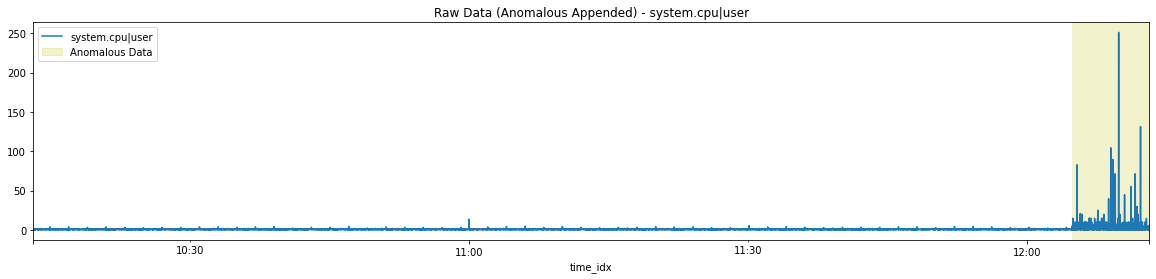

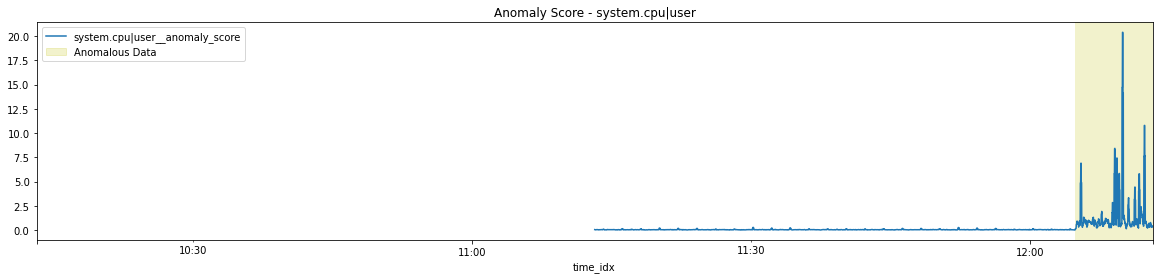

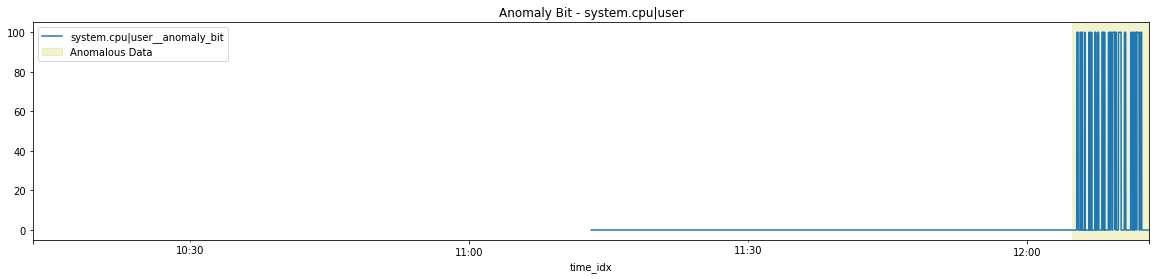

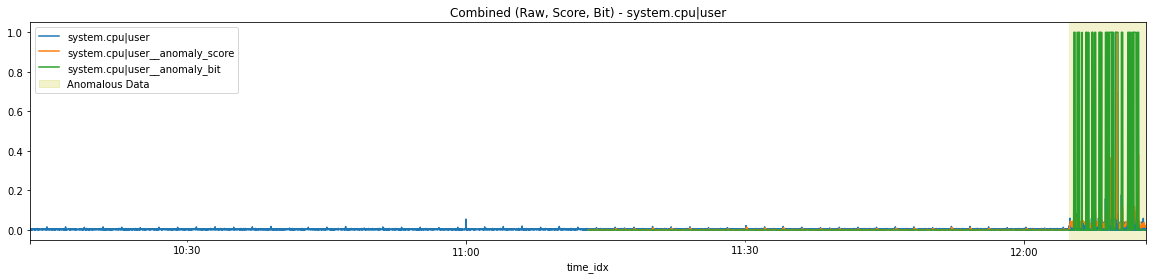

In [10]:
figsize = (20,4)

for dim in models:

    # create a dim with the raw data, anomaly score and anomaly bit for the dim
    df_final_dim = df_final[[dim,f'{dim}__anomaly_score',f'{dim}__anomaly_bit']]
    
    # plot raw data, including the anomalous data
    ax = df_final_dim[[dim]].set_index(pd.to_datetime(df_final_dim.index, unit='s')).plot(
        title=f'Raw Data (Anomalous Appended) - {dim}', figsize=figsize
    )
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')
    
    # plat the corresponding anomaly scores
    ax = df_final_dim[[f'{dim}__anomaly_score']].set_index(pd.to_datetime(df_final_dim.index, unit='s')).plot(
        title=f'Anomaly Score - {dim}', figsize=figsize
    )
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')
    
    # plot the corresponding anomaly bits
    ax = df_final_dim[[f'{dim}__anomaly_bit']].set_index(pd.to_datetime(df_final_dim.index, unit='s')).plot(
        title=f'Anomaly Bit - {dim}', figsize=figsize
    )
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')

    # finally, plot it all on the same plot (which might not be so easy or clear to read)
    df_final_dim_normalized = (df_final_dim-df_final_dim.min())/(df_final_dim.max()-df_final_dim.min())
    ax = df_final_dim_normalized.set_index(pd.to_datetime(df_final_dim_normalized.index, unit='s')).plot(
        title=f'Combined (Raw, Score, Bit) - {dim}', figsize=figsize
    )
    add_shading_to_plot(ax, df_timestamp_max - n_tail_anomalous, df_timestamp_max, 'Anomalous Data')

The last concept to introduce now is the "[anomaly rate](https://github.com/netdata/netdata/blob/master/ml/README.md#anomaly-rate)" which is really just an average over "anomaly bits".

For example, in the next cell we will just average all the anomaly bits across the light yellow window of time to find the anomaly rate for the metric within this window. 

In [11]:
# average the anomaly bits within the n_tail_anomalous period of the data
n_tail_anomalous_anomaly_rate = df_final_dim[[f'{dim}__anomaly_bit']].tail(n_tail_anomalous).mean()[0]

print(f'n_tail_anomalous_anomaly_rate = {n_tail_anomalous_anomaly_rate}%')
print(f'\nThis means the "anomaly rate" within the yellow period of anomalous data was {n_tail_anomalous_anomaly_rate}%')
print(f'\nAnother way to think of this is that {n_tail_anomalous_anomaly_rate}% of the observations during the yellow \nwindow were considered anomalous based on the latest trained model.')

n_tail_anomalous_anomaly_rate = 33.8%

This means the "anomaly rate" within the yellow period of anomalous data was 33.8%

Another way to think of this is that 33.8% of the observations during the yellow 
window were considered anomalous based on the latest trained model.


In the dataframe above we see that each observation now also has a column with the `__anomaly_score` and one with the `__anomaly_bit`.

### 5. So, how does it _actually_ work?<a id="so-how-does-it-actually-work"></a>

In this final section of the notebook below we will dig in to try understand this a bit more intuitively.

First we will "[featureize](https://brilliant.org/wiki/feature-vector/)" or "preprocess" all the data. Then we will explore what these feature vectors actually are, how they look, and how we derive anomaly scores based on their distance to the models cluster centroids.

In [12]:
# preprocess/featurize all data
df_preprocessed = preprocess_df(
    df,
    num_samples_to_lag,
    num_samples_to_diff,
    num_samples_to_smooth
)

Now that we have preprocessed all of our data, lets just take a look at it.

You will see that we have essentially just added `num_samples_to_lag` additional columns to the dataframe, one for each lag. The numbers themselves also are now longer the original raw metric values, instead they have first been differenced (just take difference of latest value with previous value so that we are working with delta's as opposed to original raw metric) and also smoothed (in this case by just averaging the previous `num_samples_to_smooth` previous differenced values).

The idea here is to define the representation that the model will work in. In this case the model will decide if a recent observation is anomalous based on it's corresponding feature vector which is a differenced, smoothed, and lagged array or list of recent values.

In [13]:
print(df_preprocessed.shape)
df_preprocessed.sample(5)

(7193, 6)


,system.cpu|user_lag0,system.cpu|user_lag1,system.cpu|user_lag2,system.cpu|user_lag3,system.cpu|user_lag4,system.cpu|user_lag5
time_idx,,,,,,
1683115616,3.308458,0.330821,1.321758,4.975124,0.833333,3.284072e-01
1683112086,0.000821,0.995846,0.000829,0.164196,0.829187,8.141636e-16
1683115402,0.006734,0.003334,0.175018,0.166658,0.488464,1.750175e-01
1683114185,0.003333,0.164196,0.331675,0.003333,0.164196,3.383417e-01
1683108938,0.001650,0.340948,0.000829,0.333333,0.166667,1.850372e-17


The model works based on these feature vectors. A lot of ML is about training a model to define some ["compressed representation"](https://en.wikipedia.org/wiki/Data_compression#Machine_learning) of the training data that can then be useful for new data in some way.

This is exactly what our cluster models are trying to do. They process a big bag of preprocessed feature vectors, covering `num_samples_to_train` raw observations, during training to come up with the best, synthetic, `n_clusters_per_dimension` feature vectors as a useful compressed representation of the training data.

The cell below will just show you what those `n_clusters_per_dimension` (in this case 2) synthetic (made up by the kemans algo) feature vectors are.

In [14]:
# lets pick the first model to look at
model = list(models.keys())[0]

# get the cluster centroids and put them in a dataframe similar to above
df_cluster_centers = pd.DataFrame(models[model]['model'].cluster_centers_, columns=df_preprocessed.columns)
df_cluster_centers.index = [f'centroid {i}' for i in df_cluster_centers.index.values]
display(df_cluster_centers)

,system.cpu|user_lag0,system.cpu|user_lag1,system.cpu|user_lag2,system.cpu|user_lag3,system.cpu|user_lag4,system.cpu|user_lag5
centroid 0,0.345630,0.352140,0.350881,0.336630,0.355123,0.352683
centroid 1,10.340862,9.944178,10.023772,10.866447,9.742318,9.862711


At inference time we can now use our `n_clusters_per_dimension` cluster centers as a sort of set of "reference" feature vectors we can compare against. 

When we see a new feature vector that is very far away from these "reference" feature vectors, we can take that as a signal that the recent data the feature vector was derived from may look significantly different than most of the data the clusters where initially train on. And as such it may be "anomalous" or "strange" in some way that might be meaningful to you are a user trying to monitor and troubleshoot systems based on these metrics.

To try make this visually clearer we will take 10 random feature vectors from the first half of our data where things were generally normal and we will also take 10 random feature vectors from the yellow anomalous period of time. Lastly we will also include the cluster centroids themselves to see how they compare to both sets of 10 feature vectors. 

Basically this is represented in the heatmap below where each row is a processed feature vectors corresponding to some timestamp `t`.

<AxesSubplot:>

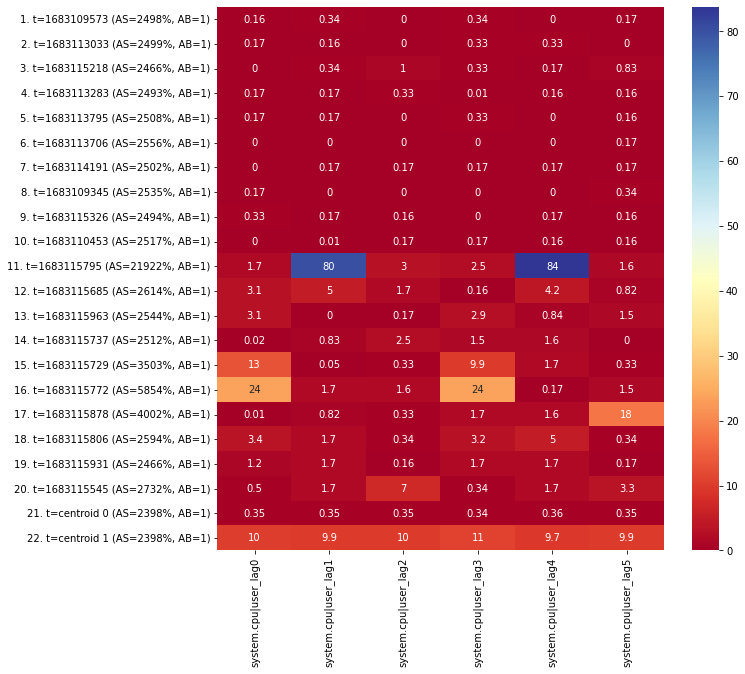

In [15]:
# prepare heatmap
df_heatmap = pd.concat([df_preprocessed.sample(10),df_preprocessed.tail(n_tail_anomalous).sample(10), df_cluster_centers])
df_heatmap = df_heatmap.round(2)

# get scores
heatmap_scores = np.sum(cdist(df_heatmap, models[dim]['model'].cluster_centers_, metric='euclidean'), axis=1)
heatmap_bits = [1 if score >= dimension_anomaly_score_threshold else 0 for score in heatmap_scores]

# add anomaly score to index
heatmap_index_inputs = list(zip(range(1, len(df_heatmap)+1), df_heatmap.index, heatmap_scores, heatmap_bits))
df_heatmap.index = [f'{x[0]}. t={x[1]} (AS={round(x[2]*100)}%, AB={x[3]})' for x in heatmap_index_inputs]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_heatmap, annot=True, ax=ax, cmap='RdYlBu')

You should see from the above heatmap that the top 10 rows all tend to have lower anomaly scores (AS) and anomaly bits (AB) that are 0. While it's the opposite for rows 11, 15, and 16.

The final two rows are the cluster centroids themselves, which should look more similar to the first 10 rows, fairly different to rows 11, 15, and 16.  Moreover, you would expect that each cluster centroid itself has a low anomaly score and non-anomalous anomaly bit.

Another way to present this visually is via line or bar plots. Below we just plot each of the rows above as a line. First all at the same time on one plot and then each one individually as a bar plot.

In the plot below the dotted lines correspond to the feature vectors sampled from the yellow anomalous period and as such we expect them to look very different to the solid lines (sampled from the normal period) and the solid circled lines which correspond to the two centroids. (Admittedly, its not the clearest of plots to read since the normal lines all bunch together).

<AxesSubplot:>

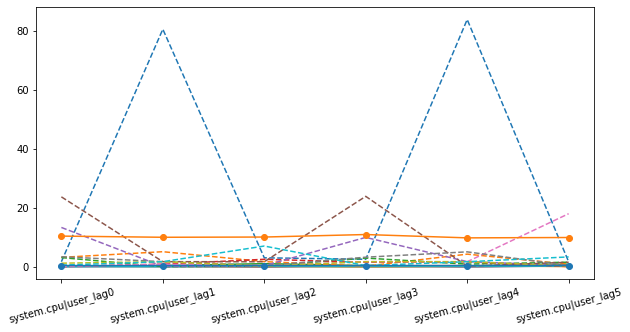

In [16]:
line_styles = ['-' for i in range(10)] + ['--' for i in range(10)] + ['o-' for i in range(2)]
df_heatmap.transpose().plot(legend=False, style=line_styles, figsize=(10,5), rot=15)

We can also just plot each feature vector itself as a bar plot with one bar for each of our 6 features. We have set the y-axis in the below plots to be fixed such that the differences are more obvious.

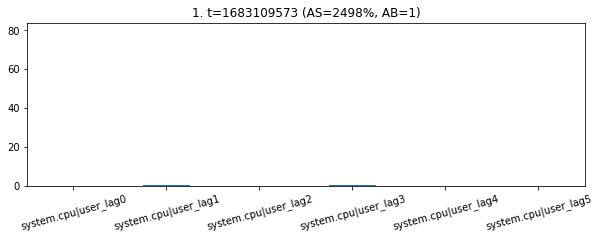

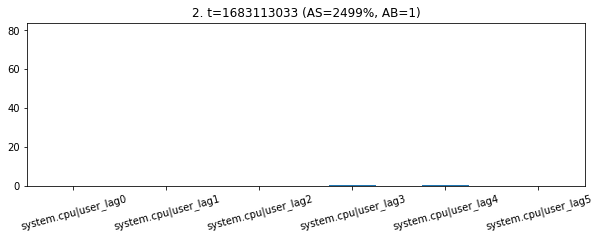

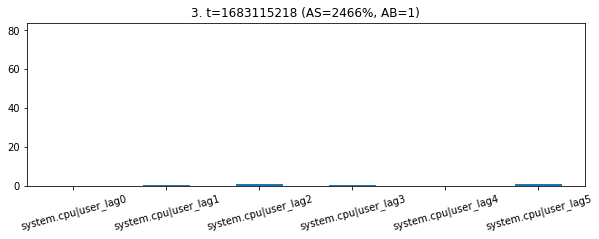

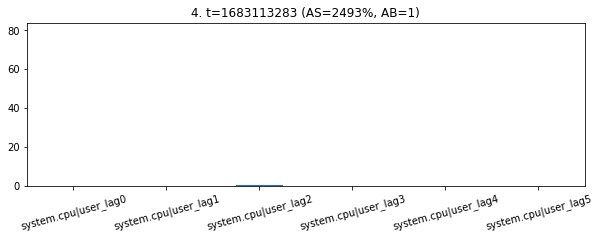

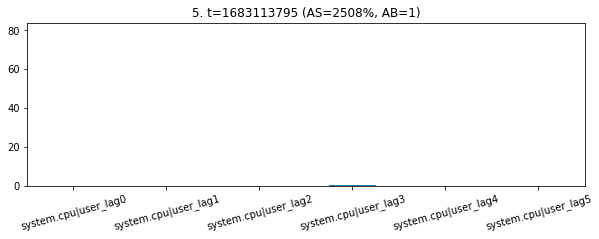

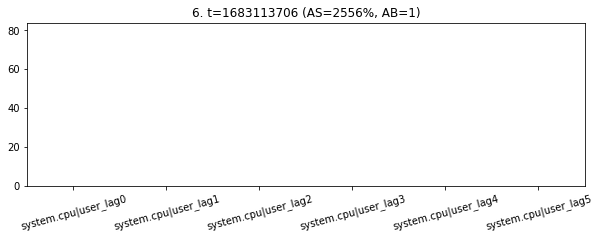

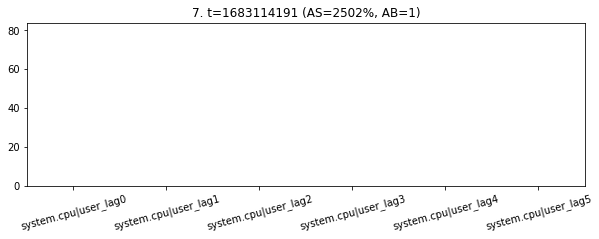

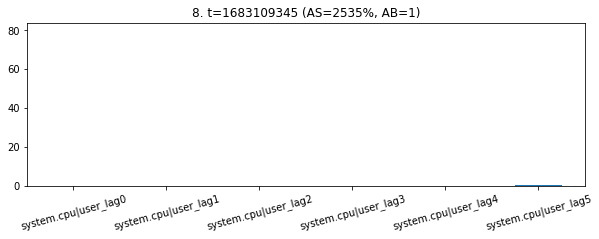

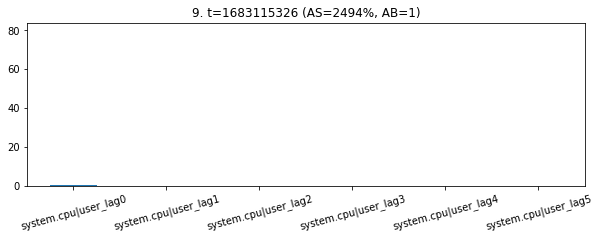

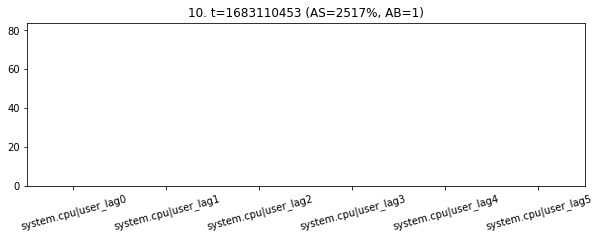

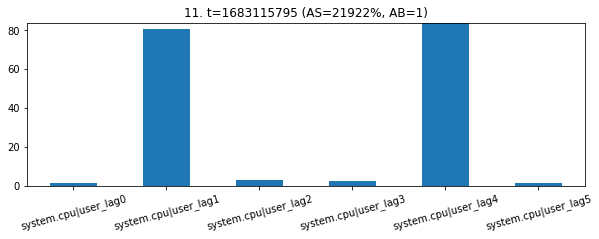

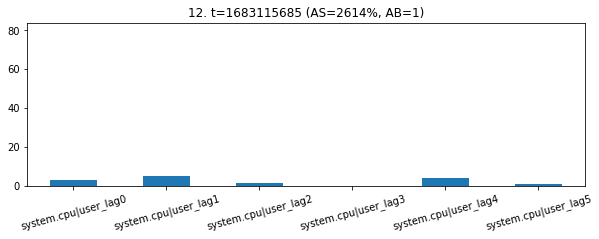

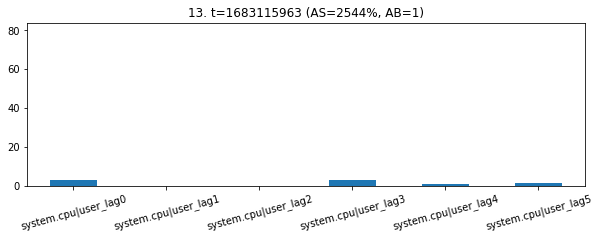

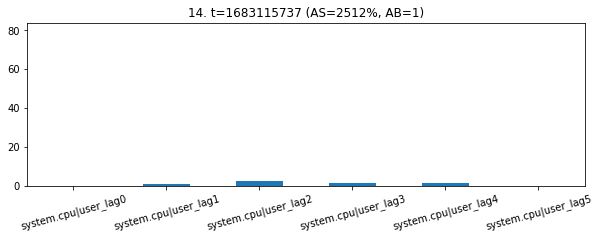

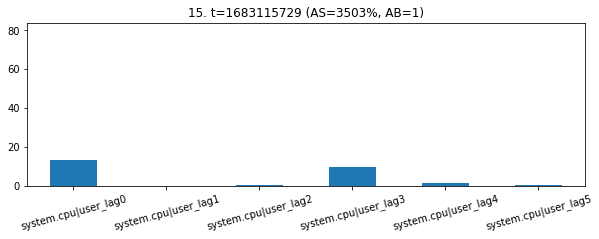

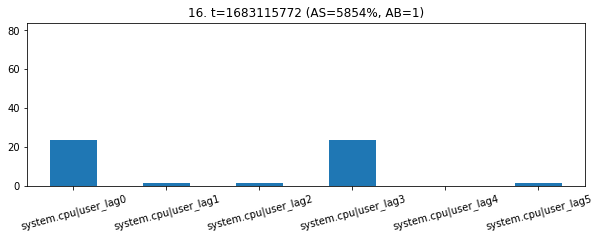

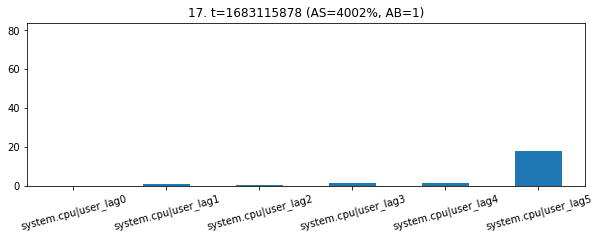

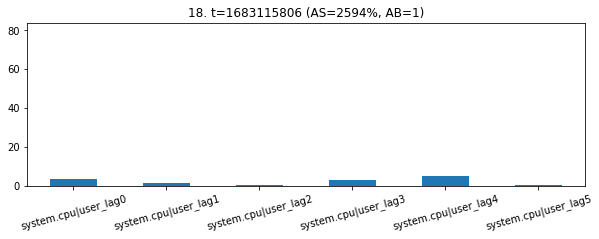

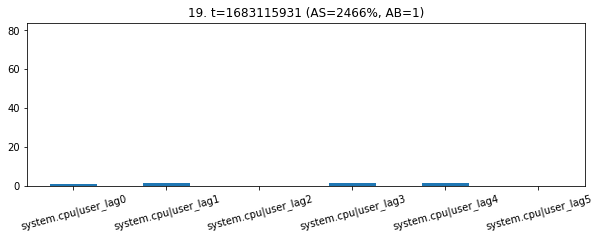

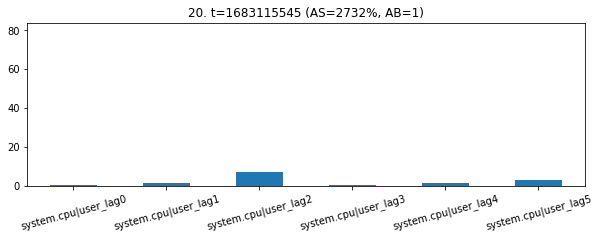

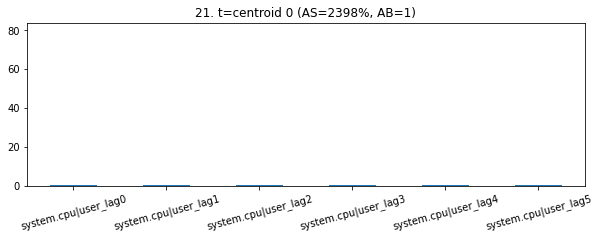

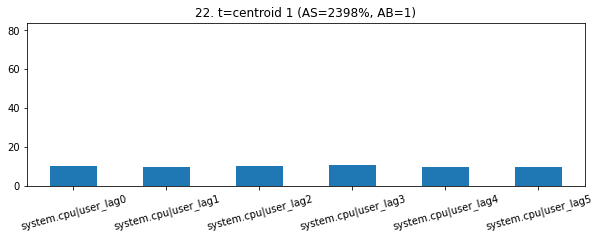

In [17]:
for i,row in df_heatmap.iterrows():
    ax = row.plot(kind='bar', figsize=(10,3),title=f'{i}', rot=15)
    ax.set_ylim(np.min(df_heatmap.values),np.max(df_heatmap.values))
    plt.show()

Lastly, an alternative way to visualize the distances between the three groups of points from the heatmap would be a series of scatter plots, one for each pair of features. 

This should give a good intuition for the distance measures (in 6 dimensional feature space, lastest preprocessed observation plus the 5 lagged values) that underpin the raw anomaly score.

Generally, we would expect to see the blue 'normal' points group closer together and 'near' the green cluster centroids, meanwhile the anomalous orange points should tend to be further away from the other two groups.

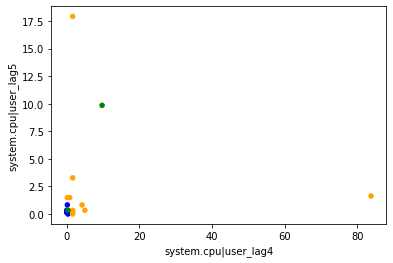

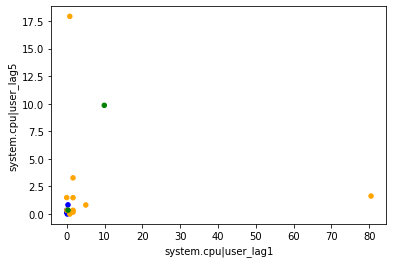

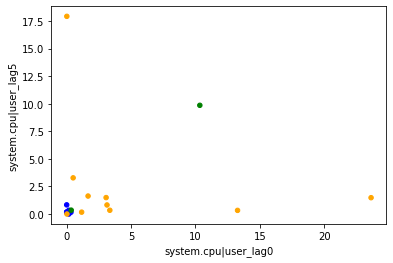

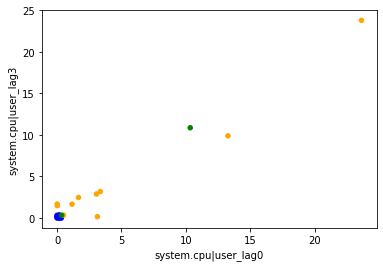

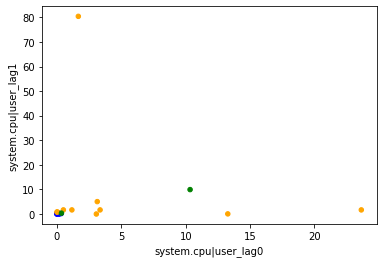

In [18]:
# get list of feature pair combinations
feature_pairs = list(itertools.combinations(df_heatmap.columns, 2))
feature_pairs_sample = random.sample(feature_pairs,5) # just sample 5 pairs

# define colors of points
point_colors = ['blue' for i in range(10)] + ['orange' for i in range(10)] + ['green' for i in range(2)]

# plot each pair of features
for feature_pair in feature_pairs_sample:
    df_heatmap.plot.scatter(x=feature_pair[0], y=feature_pair[1], color=point_colors, subplots=True)

...

You made it! Congratualtions to getting all the way to the end (its ok if you just skipped here too), as a reward [here](https://youtube.com/playlist?list=PL6Zhl9mK2r0Ja7SKX72rD4dfBNnaQbbwR) is a playlist of interesting data science and machine learning youtube videos that you might like considering you just read a jupyter notebook about using kmeans to do unsupervised anomaly detection :)